In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [2]:
df = pd.read_csv('ratings.csv')
df.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
userId = {val: i for i,val in enumerate(df['userId'].unique())}
movieId = {val: i for i,val in enumerate(df['movieId'].unique())}

df['userId'] = df['userId'].apply(lambda x:userId[x])
df['movieId'] = df['movieId'].apply(lambda x:movieId[x])

In [5]:
np.random.seed(2022)
train_num = int(len(df['userId']) * 0.9)
indice = np.random.permutation(len(df['userId']))
train_indice = indice[:train_num]
test_indice = indice[train_num:]
x_train = df.loc[train_indice,['userId','movieId']].values
x_test = df.loc[test_indice,['userId','movieId']].values
y_train = df.loc[train_indice,['rating']].values
y_test = df.loc[test_indice,['rating']].values

In [26]:
def objective(U,V,X,Y,lam=1):
    result = lam * (norm(U,ord='fro')**2 + norm(V,ord='fro')**2)
    for idx,(i,j) in enumerate(X):
        result += (Y[idx] - np.dot(U[i],V[j]))**2
    result /= 2
    return result
        

def learn(U_init,V_init,Xtrain,Ytrain,lr=0.01,max_iter=50,lam=1):
    U = U_init
    V = V_init
    f_record = []
    for t in tqdm(range(max_iter)):
        f = objective(U,V,Xtrain,Ytrain,lam=lam)
        f_record.append(f)
        for idx,(i,j) in enumerate(Xtrain):
            E_ij = np.dot(U[i],V[j]) - Ytrain[idx]
            U[i] = U[i] - lr * (E_ij * V[j] + lam*U[i])
            V[j] = V[j] - lr * (E_ij * U[i] + lam*V[j])
        new_order = np.random.permutation(len(Xtrain))
        Xtrain = Xtrain[new_order]
        Ytrain = Ytrain[new_order]
    return U,V,f_record

def rmse_cal(U,V,Xtest,Ytest):
    result = 0
    Y = np.zeros_like(Ytest)
    for idx,(i,j) in enumerate(Xtest):
        Y[idx] = np.dot(U[i],V[j])
    result = np.sqrt(np.mean((Y-Ytest)**2))
    return result
    

In [27]:
n = len(userId)
m = len(movieId)
k = 50
U_init = np.random.randn(n,k)
V_init = np.random.randn(m,k)
U_learn,V_learn,record = learn(U_init,V_init,x_train,y_train,max_iter=50)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:20<00:00,  2.81s/it]


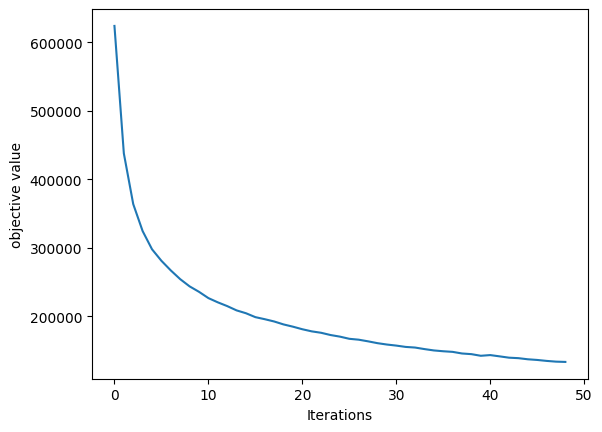

In [28]:
fig = plt.figure()
plt.plot(record[1:])
plt.xlabel('Iterations')
plt.ylabel('objective value')
plt.show()

In [29]:
rmse_cal(U_learn,V_learn,x_test,y_test)

1.5189218190659817

In [30]:
lam_list = [1e-6,1e-3,0.1,0.5,2,5,10,20,50,100,500,1000]
RMSE_list = []
for lam in lam_list:
    U_learn,V_learn,record = learn(U_init,V_init,x_train,y_train)
    rmse = rmse_cal(U_learn,V_learn,x_test,y_test)
    RMSE_list.append(rmse)
RMSE_list

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:57<00:00,  2.34s/it]


[1.5103795728152116,
 1.5023719071031378,
 1.5068764739643317,
 1.507491179967951,
 1.502639384380287,
 1.5027328314864516,
 1.5062422812945915,
 1.5008539351011425,
 1.5040030281495465,
 1.5029726762553597,
 1.5021789998378967,
 1.5016130738676063]

In [34]:
np.round(RMSE_list,4)

array([1.5104, 1.5024, 1.5069, 1.5075, 1.5026, 1.5027, 1.5062, 1.5009,
       1.504 , 1.503 , 1.5022, 1.5016])

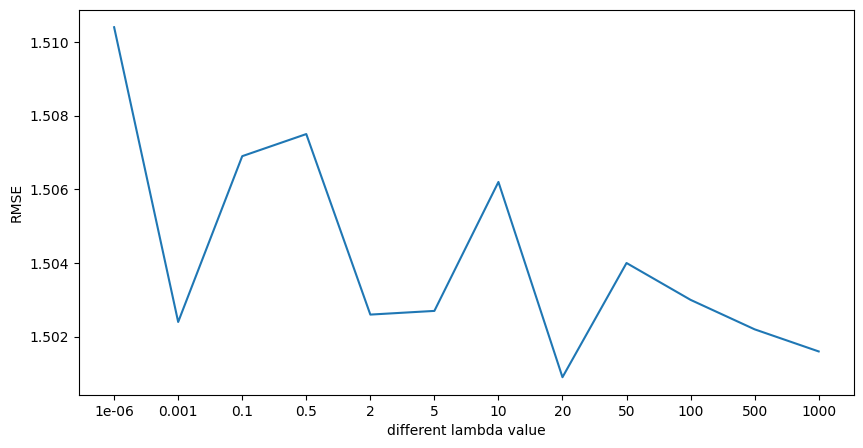

In [32]:
fig = plt.figure(figsize=(10,5))
plt.plot(RMSE_list)
plt.xlabel('different lambda value')
plt.ylabel('RMSE')
plt.xticks(range(len(lam_list)),lam_list)
plt.show()